In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm  
from helpers import load_dataset_paths, load_vep_csv, summarize_results_and_save
import pywt
from featex import FeatureExtractor
from CNN_classifier import MultiBranchCNN

## 0. Loading Preprocessed Files and Metadata

In [2]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")

PRIMA BC_Only files: 132
PRIMA RGC_Only files: 66
PRIMA BC_and_RGC files: 20


## 2. Feature extraction

### Multichannel DWT

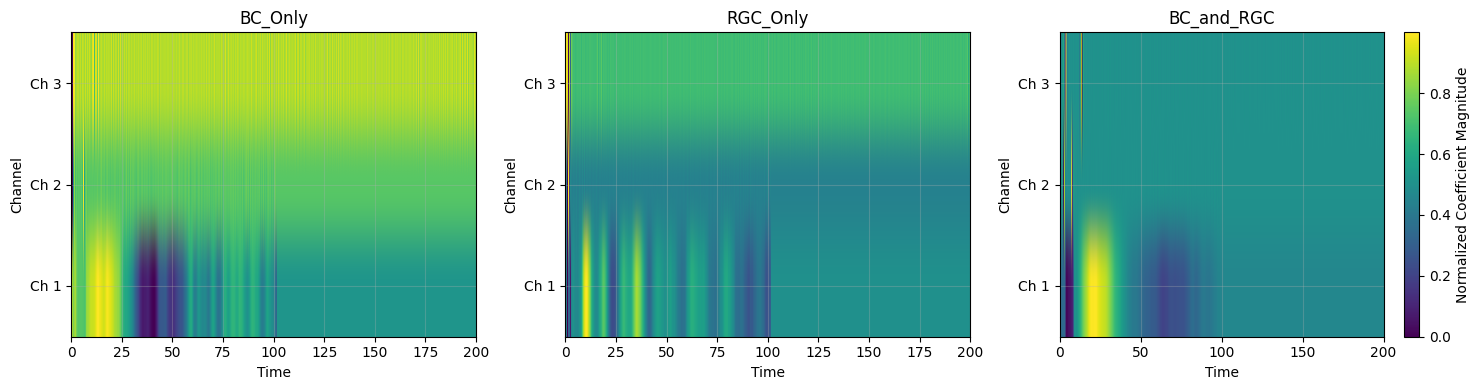

In [3]:
featex = FeatureExtractor()
dwt_data = {}

# --- Compute CWT scalograms ---
for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
    file_list = all_paths["PRIMA"][label]

    for file in file_list:
        time, signal = load_vep_csv(file, t_min=0, t_max=200, normalize=True)

        features = featex.extract_dwt_features_multi_channel(signal, level=2, wavelet='db4')
        dwt_data[file] = {"features": features, "label": label}

unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
plt.figure(figsize=(15, 4))

for i, label in enumerate(unique_labels, 1):
    plt.subplot(1, 3, i)
    
    # Pick 1 example from this class
    example_files = [f for f in dwt_data if dwt_data[f]["label"] == label][:1]
    file = example_files[0]
    data = dwt_data[file]["features"]    
    channels, time_points = data.shape
    data_viz = np.array([(ch - ch.min()) / (ch.max() - ch.min() + 1e-8) for ch in data])
    plt.imshow(data_viz, aspect='auto', extent=[time[0], time[-1], 0, channels], cmap='viridis', origin='lower')
    #plt.imshow(data, aspect='auto', extent=[time[0], time[-1], 0, channels], cmap='viridis', origin='lower')
    plt.title(f"{label}")
    plt.xlabel("Time")
    #plt.yticks(np.arange(channels)+0.5, ['A4', 'D4', 'D3', 'D2', 'D1'])
    plt.yticks(np.arange(channels)+0.5, [f"Ch {i+1}" for i in range(channels)])
    plt.ylabel("Channel")
    plt.grid(alpha=0.3)
plt.colorbar(label='Normalized Coefficient Magnitude')
plt.tight_layout()
plt.show()

# D1 highest Detail, A4 lowest Approximation

### WPD

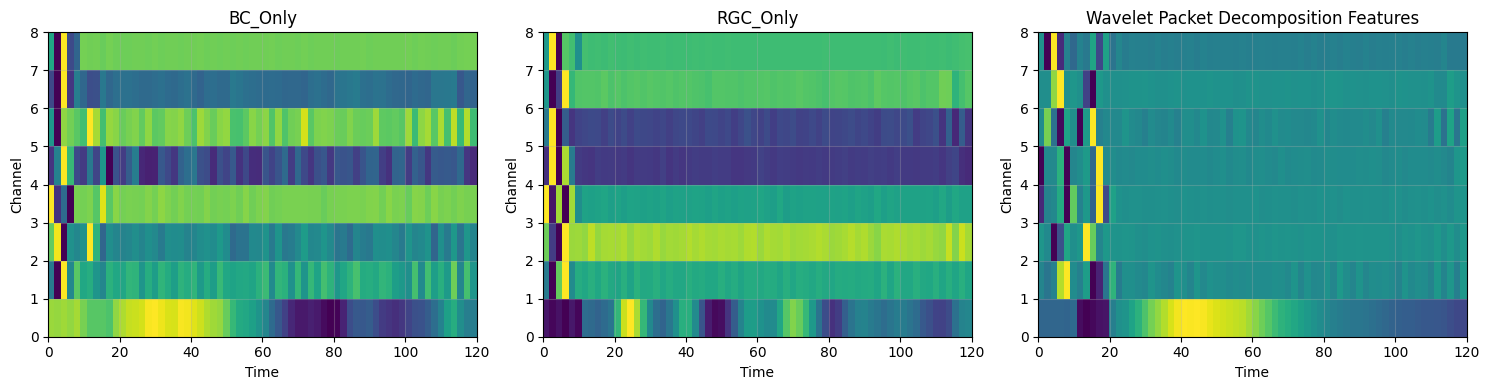

In [4]:
featex = FeatureExtractor()
wpd_data = {}

# --- Compute CWT scalograms ---
for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
    file_list = all_paths["PRIMA"][label]

    for file in file_list:
        time, signal = load_vep_csv(file, t_min=0, t_max=120, normalize=True)

        features = featex.extract_wpd_features(signal, level=3, wavelet='db4')
        wpd_data[file] = {"features": features, "label": label}

unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
plt.figure(figsize=(15, 4))

for i, label in enumerate(unique_labels, 1):
    plt.subplot(1, 3, i)
    
    # Pick 1 example from this class
    example_files = [f for f in wpd_data if wpd_data[f]["label"] == label][:1]
    file = example_files[0]
    data = wpd_data[file]["features"]    
    channels, time_points = data.shape
    #plt.imshow(data, aspect='auto', extent=[0, 1, 0, channels], cmap='viridis', origin='lower')
    data_viz = np.array([(ch - ch.min()) / (ch.max() - ch.min() + 1e-8) for ch in data])
    plt.imshow(data_viz, aspect='auto', extent=[time[0], time[-1], 0, channels], cmap='viridis', origin='lower')
    plt.title(f"{label}")
    plt.xlabel("Time")
    plt.ylabel("Channel")
    plt.grid(alpha=0.3)
plt.title("Wavelet Packet Decomposition Features")
plt.tight_layout()
plt.show()

## Classification

--- Experiment 1 ---
Number of training samples: 60, epochs: 30, batch size: 4

----- Fold 1 -----
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.3500 - loss: 1.1084 - val_accuracy: 0.3500 - val_loss: 1.0950
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5000 - loss: 1.0532 - val_accuracy: 0.6000 - val_loss: 1.0900
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5500 - loss: 0.9987 - val_accuracy: 0.6500 - val_loss: 1.0805
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5500 - loss: 0.9768 - val_accuracy: 0.6500 - val_loss: 1.0676
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6000 - loss: 0.8894 - val_accuracy: 0.6500 - val_loss: 1.0515
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 0.8199 - val_accuracy: 0.6500 - val_loss: 1.0250
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7500 - loss: 0.7515 - val_accuracy: 0.8000 - val_loss: 0.9879
Epoch 8/30
10/10 

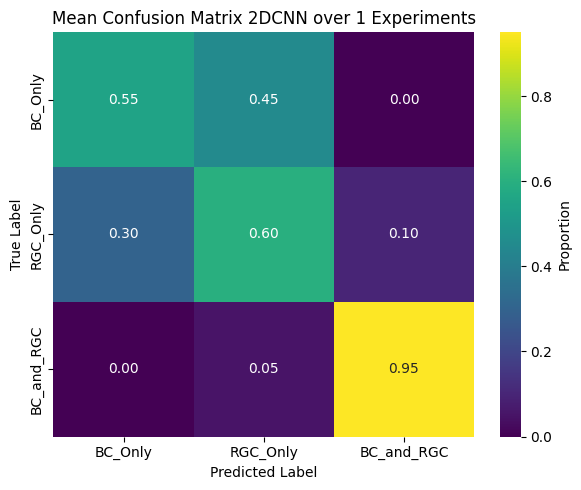

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from CNN_classifier import AttentionLayer
from tensorflow.keras import models

average_results = {}
n_experiments = 1

all_conf_matrices = []
results = []
for experiments in range(n_experiments):
    print(f"--- Experiment {experiments + 1} ---")
    np.random.seed(42)
    no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
    sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
    sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
    sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

    X, labels = [], []
    feature_list = []
    for label, file_list in zip(
        ["BC_Only", "RGC_Only", "BC_and_RGC"],
        [sampled_BC, sampled_RGC, sampled_BC_and_RGC]):
        for file in file_list:
            _, signal = load_vep_csv(file, t_min=0, t_max=200)
            #features = featex.extract_dwt_features_multi_channel(signal, wavelet='db4', level=4)
            features = featex.extract_wpd_features(signal, wavelet='db4', level=4)
            feature_list.append(features)
            labels.append(label)

       
    label_encoder = {'BC_Only': 0, 'RGC_Only': 1, 'BC_and_RGC': 2}
    label_decoder = {v: k for k, v in label_encoder.items()}
    X = np.stack([features for features in feature_list]) 
    #print("Feature shapes:")
    #print([feat.shape for feat in X])
    X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-8)


    n_train = len(X)
    #batch_size = max(4, min(32, n_train // 10))
    batch_size = 4
    epochs = 30
    print(f"Number of training samples: {n_train}, epochs: {epochs}, batch size: {batch_size}")

    y = np.array([label_encoder[l] for l in labels])
    time_len = X.shape[2]
    n_branches = X.shape[1]
    clf = MultiBranchCNN(input_shape=(time_len, 1), n_branches=n_branches, n_classes=3)
    y_true, y_pred, _ = clf.fit(X, y, n_splits=3, epochs=epochs, batch_size=batch_size)
    metrics = clf.evaluate(y_true, y_pred, label_encoder, label_decoder)
    print(metrics)

    results.append({
            "Accuracy": metrics["accuracy"],
            "BalancedAcc": metrics["balanced_accuracy"],
            "F1": metrics["f1_score"],
            "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
            "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
            "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
        })
    y_true_labels = [label_decoder[i] for i in y_true]
    y_pred_labels = [label_decoder[i] for i in y_pred]
    all_conf_matrices.append(
        confusion_matrix(
            y_true_labels, y_pred_labels, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
        )
    )

    # -------------------------
    #  Extract Attention Weights for Validation Set
    # -------------------------
    # Create a version of the attention layer that returns weights
    att_layer = AttentionLayer(return_attention=True)
    merged_output = clf.model.get_layer("merged_subbands").output


    # Reapply the attention layer in "return_attention=True" mode
    context, attention_weights = att_layer(merged_output)

    # Build a small model that outputs only attention weights
    attention_extractor = models.Model(
        inputs=clf.model.inputs,
        outputs=attention_weights
    )

    # Use the validation fold data (from your last fold or redefined fold loop)
    X_all = [X[:, i, :][:, :, np.newaxis] for i in range(X.shape[1])]
    att_maps = attention_extractor.predict(X_all)
    y_all = y

    unique_classes = np.unique(y_all)
    mean_att_per_class = {
        cls: att_maps[y_all == cls].mean(axis=0).squeeze()
        for cls in unique_classes
    }
    print("Mean Attention Weights per Class:")
    for cls, att in mean_att_per_class.items():
        print(f"Class {cls}: {att}")



accs = [r["Accuracy"] for r in results]
balanced_accs = [r["BalancedAcc"] for r in results]
f1s = [r["F1"] for r in results]
bc_accs = [float(r["Acc BC_Only"]) for r in results]
rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

average_results = {
    "Accuracy_mean": np.mean(accs),
    "Accuracy_std": np.std(accs),
    "BalancedAcc_mean": np.mean(balanced_accs),
    "BalancedAcc_std": np.std(balanced_accs),
    "F1_mean": np.mean(f1s),
    "F1_std": np.std(f1s),

    # per-class accuracies (recall)
    "Acc_BC_Only_mean": np.mean(bc_accs),
    "Acc_BC_Only_std": np.std(bc_accs),
    "Acc_RGC_Only_mean": np.mean(rgc_accs),
    "Acc_RGC_Only_std": np.std(rgc_accs),
    "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
    "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
}
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

plt.figure(figsize=(6,5))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", 
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'})

plt.title(f"Mean Confusion Matrix 2DCNN over {n_experiments} Experiments")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [6]:
summarize_results_and_save(average_results, model_name="MultiBranchCNN")


Top 10 setups by F1 Score:
         Model F1 (mean ± std) BC_Only (mean ± std) RGC_Only (mean ± std) BC_and_RGC (mean ± std)
MultiBranchCNN     0,698 ± 0,0           0,55 ± 0,0            0,95 ± 0,0               0,6 ± 0,0

Summary saved to: results/MultiBranchCNN_average_classification_results.csv
